A notebook to investigate the albedo dynamics in the dark zone.

In [2]:
import ee
import geemap
from geemap import cartoee
import cartopy.crs as ccrs
# import geemap.colormaps as cm
import matplotlib.pyplot as plt
# from geetools import batch
import numpy as np
import pandas as pd
import seaborn as sns
# import time 

In [2]:
Map = geemap.Map()
Map 

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

# Prepare aoi and ice mask

In [3]:
greenlandmask = ee.Image('OSU/GIMP/2000_ICE_OCEAN_MASK') \
                   .select('ice_mask').eq(1) #'ice_mask', 'ocean_mask'
# arcticDEM = ee.Image('UMN/PGC/ArcticDEM/V3/2m_mosaic')

# arcticDEMgreenland = arcticDEM.updateMask(greenlandmask)

# visPara = {'min': 0,  'max': 3000.0, 'palette': ['0d13d8', '60e1ff', 'ffffff']}
# visPara = {'min': 0,  'max': 3000.0, 'palette': palette}

# Map.addLayer(arcticDEMgreenland, visPara, 'Arctic DEM terrain')
Map.setCenter(-41.0, 74.0, 3)
# Map.add_colorbar(visPara, label="Elevation (m)", discrete=False, orientation="vertical", layer_name="Arctic DEM terrain")

In [4]:
# aoi = ee.Image('OSU/GIMP/2000_ICE_OCEAN_MASK').geometry().bounds() # this is too large, discarded
# aoi = ee.Geometry.Polygon(
#     [[[-36.29516924635421, 83.70737243835941],
#     [-51.85180987135421, 82.75597137647488],
#     [-61.43188799635421, 81.99879137488564],
#     [-74.08813799635422, 78.10103528196419],
#     [-70.13305987135422, 75.65372336709613],
#     [-61.08032549635421, 75.71891096312955],
#     [-52.20337237135421, 60.9795530382023],
#     [-43.41430987135421, 58.59235996703347],
#     [-38.49243487135421, 64.70478286561182],
#     [-19.771731746354217, 69.72271161037442],
#     [-15.728762996354217, 76.0828635948066],
#     [-15.904544246354217, 79.45091003031243],
#     [-10.015872371354217, 81.62328742628017],
#     [-26.627200496354217, 83.43179828852398],
#     [-31.636966121354217, 83.7553561747887]]]
# ) # whole greenland
# aoi = ee.Geometry.Polygon(
#     [[[-75.35327725640606, 78.15797707936824],
#       [-58.137306661848434, 69.59945512283268],
#       [-51.82415036596651, 59.897134149764156],
#       [-42.233465551083604, 59.260337764670496],
#       [-61.95501079278244, 79.65995314962508]]]
# ) # western greenland
# aoi = ee.Geometry.Polygon(
#     [[[-57.19932402786638, 71.06394313461017],
#       [-57.19932402786638, 63.62039597689339],
#       [-44.45518340286638, 63.62039597689339],
#       [-44.45518340286638, 71.06394313461017]]]
# ) # darkzone
aoi = ee.Geometry.Polygon(
        [[[-51.26670684036638, 71.10667904834996],
          [-50.613642172036386, 69.35172505065574],
          [-51.925886527866396, 67.4097894479071],
          [-51.20992413915373, 66.27518798747208],
          [-51.86713118464301, 66.04083709002118],
          [-51.68516540592766, 65.85920268639616],
          [-50.14610137161638, 63.77010325395928],
          [-44.45518340286638, 63.62039597689339],
          [-44.45518340286638, 71.06394313461017]]]) # only connected ice
Map.addLayer(aoi, {}, 'aoi')

'''
how to get corner coordinates: 
https://gis.stackexchange.com/questions/318959/get-lon-lat-of-a-top-left-corner-for-geometry-in-google-earth-engine
'''
listCoords = ee.Array.cat(aoi.coordinates(), 1); 

# get the X-coordinates
xCoords = listCoords.slice(1, 0, 1)
yCoords = listCoords.slice(1, 1, 2)

xMin = xCoords.reduce('min', [0]).get([0,0]).getInfo()
xMax = xCoords.reduce('max', [0]).get([0,0]).getInfo()
yMin = yCoords.reduce('min', [0]).get([0,0]).getInfo()
yMax = yCoords.reduce('max', [0]).get([0,0]).getInfo()

'''
alternatively, https://gist.github.com/graydon/11198540
list of country-bounding-boxes
'GL': ('Greenland', (-73.297, 60.03676, -12.20855, 83.64513)),
'''
# xMin = -73.297
# xMax = -12.20855
# yMin = 60.03676
# yMax = 83.64513


"\nalternatively, https://gist.github.com/graydon/11198540\nlist of country-bounding-boxes\n'GL': ('Greenland', (-73.297, 60.03676, -12.20855, 83.64513)),\n"

# Prepare Harmonized Albedo

In [5]:
date_start = ee.Date.fromYMD(1984, 1, 1)
date_end = ee.Date.fromYMD(2020, 12, 31)


# yearnum = 2020

# date_start = ee.Date.fromYMD(yearnum, 1, 1)
# date_end = ee.Date.fromYMD(yearnum, 12, 1)
# titlestr = "albedo " + str(yearnum)# + "-" + str(yearnum+4)

In [6]:
def addTotalAlbedo(image):
    albedo = image.expression(
        '1.0065 * Blue + 1.1902 * Green - 2.6738 * Red + 1.1700 * NIR + 0.9211 * SWIR1 - 1.1667 * SWIR2 + 0.1757',
        {
            'Blue': image.select('Blue'),
            'Green': image.select('Green'),
            'Red': image.select('Red'),
            'NIR': image.select('NIR'),
            'SWIR1': image.select('SWIR1'),
            'SWIR2': image.select('SWIR2')
        }
    ).rename('totalAlbedo')
    return image.addBands(albedo).copyProperties(image, ['system:time_start'])

def addVisnirAlbedo(image):
    albedo = image.expression(
        '0.7605 * Blue + 0.8090 * Green - 1.8376 * Red + 0.9145 * NIR + 0.1627',
        {
            'Blue': image.select('Blue'),
            'Green': image.select('Green'),
            'Red': image.select('Red'),
            'NIR': image.select('NIR')
        }
    ).rename('visnirAlbedo')
    return image.addBands(albedo).copyProperties(image, ['system:time_start'])


## If VIZ-NIR bands albedo

In [7]:
''''if viz-nir bands albedo'''
rmaCoefficients = {
  'itcpsL7': ee.Image.constant([-0.0084, -0.0065, 0.0022, -0.0768]),
  'slopesL7': ee.Image.constant([1.1017, 1.0840, 1.0610, 1.2100]),
  'itcpsS2': ee.Image.constant([0.0210, 0.0167, 0.0155, -0.0693]),
  'slopesS2': ee.Image.constant([1.0849, 1.0590, 1.0759, 1.1583])
}; #rma
# Function to get and rename bands of interest from OLI.
def renameOli(img):
  return img.select(
    ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'QA_PIXEL', 'QA_RADSAT'], #'QA_PIXEL', 'QA_RADSAT'
    ['Blue',  'Green', 'Red',   'NIR',   'QA_PIXEL', 'QA_RADSAT']) #'QA_PIXEL', 'QA_RADSAT'

# Function to get and rename bands of interest from ETM+, TM.
def renameEtm(img):
  return img.select(
    ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'QA_PIXEL', 'QA_RADSAT'], #,   'QA_PIXEL', 'QA_RADSAT'
    ['Blue',  'Green', 'Red',   'NIR',   'QA_PIXEL', 'QA_RADSAT']) #, 'QA_PIXEL', 'QA_RADSAT'

# Function to get and rename bands of interest from Sentinel 2.
def renameS2(img):
  return img.select(
    ['B2',   'B3',    'B4',  'B8',  'QA60', 'SCL'],
    ['Blue', 'Green', 'Red', 'NIR', 'QA60', 'SCL']
  )

def oli2oli(img):
  return img.select(['Blue', 'Green', 'Red', 'NIR']) \
    .toFloat()

def etm2oli(img):
  return img.select(['Blue', 'Green', 'Red', 'NIR']) \
    .multiply(rmaCoefficients["slopesL7"]) \
    .add(rmaCoefficients["itcpsL7"]) \
    .toFloat()
    # .round() \
    # .toShort() 
    # .addBands(img.select('pixel_qa'))

def s22oli(img):
  return img.select(['Blue', 'Green', 'Red', 'NIR']) \
    .multiply(rmaCoefficients["slopesS2"]) \
    .add(rmaCoefficients["itcpsS2"]) \
    .toFloat()
    # .round() \
    # .toShort() # convert to Int16
    # .addBands(img.select('pixel_qa'))

def imRangeFilter(image):
  maskMax = image.lt(1)
  maskMin = image.gt(0)
  return image.updateMask(maskMax).updateMask(maskMin)

'''
Cloud mask for Landsat data based on fmask (QA_PIXEL) and saturation mask 
based on QA_RADSAT.
Cloud mask and saturation mask by sen2cor.
Codes provided by GEE official. '''

# the Landsat 8 Collection 2
def maskL8sr(image):
  # Bit 0 - Fill
  # Bit 1 - Dilated Cloud
  # Bit 2 - Cirrus
  # Bit 3 - Cloud
  # Bit 4 - Cloud Shadow
  qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
  saturationMask = image.select('QA_RADSAT').eq(0)

  # Apply the scaling factors to the appropriate bands.
  # opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  # thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)

  # Replace the original bands with the scaled ones and apply the masks.
  #image.addBands(opticalBands, {}, True) \ maybe not available in python api
  return image.select(['Blue', 'Green', 'Red', 'NIR']).multiply(0.0000275).add(-0.2) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)

  
# the Landsat 4, 5, 7 Collection 2
def maskL457sr(image):
  # Bit 0 - Fill
  # Bit 1 - Dilated Cloud
  # Bit 2 - Unused
  # Bit 3 - Cloud
  # Bit 4 - Cloud Shadow
  qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
  saturationMask = image.select('QA_RADSAT').eq(0)

  # Apply the scaling factors to the appropriate bands.
  # opticalBands = image.select('SR_B.')
  # opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  # thermalBand = image.select('ST_B6').multiply(0.00341802).add(149.0)

  # Replace the original bands with the scaled ones and apply the masks.
  return image.select(['Blue', 'Green', 'Red', 'NIR']).multiply(0.0000275).add(-0.2) \
      .updateMask(qaMask) \
      .updateMask(saturationMask)
 #
 # Function to mask clouds using the Sentinel-2 QA band
 # @param {ee.Image} image Sentinel-2 image
 # @return {ee.Image} cloud masked Sentinel-2 image
 #
def maskS2sr(image):
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11
  # Bits 1 is saturated or defective pixel
  not_saturated = image.select('SCL').neq(1)
  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudBitMask).eq(0) \
      .And(qa.bitwiseAnd(cirrusBitMask).eq(0)) 

  return image.updateMask(mask).updateMask(not_saturated)


In [8]:
# Define function to prepare OLI images.
def prepOli(img):
  orig = img
  img = renameOli(img)
  img = maskL8sr(img)
  img = oli2oli(img)
  # img = addTotalAlbedo(img)
  img = addVisnirAlbedo(img)
  return ee.Image(img.copyProperties(orig, orig.propertyNames()))

# Define function to prepare ETM+/TM images.
def prepEtm(img):
  orig = img
  img = renameEtm(img)
  img = maskL457sr(img)
  img = etm2oli(img)
  # img = addTotalAlbedo(img)
  img = addVisnirAlbedo(img)
  return ee.Image(img.copyProperties(orig, orig.propertyNames()))

# Define function to prepare S2 images.
def prepS2(img):
  orig = img
  img = renameS2(img)
  img = maskS2sr(img)
  img = s22oli(img)
  # img = addTotalAlbedo(img)
  img = addVisnirAlbedo(img)
  return ee.Image(img.copyProperties(orig, orig.propertyNames()).set('SATELLITE', 'SENTINEL_2'))


In [9]:
# create filter for image collection
colFilter = ee.Filter.And(
    ee.Filter.geometry(aoi), # filterbounds not available on python api https://github.com/google/earthengine-api/issues/83
    ee.Filter.date(date_start, date_end),
    ee.Filter.calendarRange(7, 8, 'month'),
    # ee.Filter.lt('CLOUD_COVER', 50)
)

s2colFilter =  ee.Filter.And(
    ee.Filter.geometry(aoi), # filterbounds not available on python api https://github.com/google/earthengine-api/issues/83
    ee.Filter.date(date_start, date_end),
    ee.Filter.calendarRange(7, 8, 'month'),
    ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50)
)

oliCol = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
            .filter(colFilter) \
            .map(prepOli) \
            .select(['visnirAlbedo']) # .select(['totalAlbedo']) or  .select(['viznirAlbedo'])
etmCol = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
            .filter(colFilter) \
            .map(prepEtm) \
            .select(['visnirAlbedo']) # .select(['totalAlbedo']) or  .select(['viznirAlbedo'])
tmCol = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
            .filter(colFilter) \
            .map(prepEtm) \
            .select(['visnirAlbedo']) # .select(['totalAlbedo']) or  .select(['viznirAlbedo'])
tm4Col = ee.ImageCollection('LANDSAT/LT04/C02/T1_L2') \
            .filter(colFilter) \
            .map(prepEtm) \
            .select(['visnirAlbedo']) # .select(['totalAlbedo']) or  .select(['viznirAlbedo'])
s2Col = ee.ImageCollection('COPERNICUS/S2_SR') \
            .filter(s2colFilter) \
            .map(prepS2) \
            .select(['visnirAlbedo']) # .select(['totalAlbedo']) or  .select(['viznirAlbedo'])
landsatCol = oliCol.merge(etmCol).merge(tmCol).merge(tm4Col)
multiSat = landsatCol.merge(s2Col).map(imRangeFilter).sort('system:time_start', True)


# Anomaly

In [22]:
date_init = ee.Date.fromYMD(2005, 1, 1)
# Difference between start and finish
diff = date_end.difference(date_init, 'month')

# Make a list of all dates
timestep = 1; # steps of day number

range = ee.List.sequence(0, diff.subtract(1), timestep).map(lambda month: date_init.advance(month,'month'))

# Funtion for iteraton over the range of dates
def getMonthly(date, newlist):
  # Cast
    date = ee.Date(date)
    newlist = ee.List(newlist)

    # Filter collection between date and the next day
    filtered = multiSat.filterDate(date, date.advance(timestep,'month'))
    #   nimproperty = filtered.get()
    # Make the mosaic
    image = ee.Image(
        filtered.mean().copyProperties(filtered.first())) \
        .set('system:time_start', filtered.first().get('system:time_start'))

    # Add the mosaic to a list only if the collection has images
    return ee.List(ee.Algorithms.If(filtered.size(), newlist.add(image), newlist))

monthlyAlbedo = ee.ImageCollection(ee.List(range.iterate(getMonthly, ee.List([]))))

In [23]:
# get the average  
meanAlbedo = multiSat.filterDate('1984-01-01', '2004-12-31').mean()
reference = multiSat.filterDate('1984-01-01', '2004-12-31').sort('system:time_start', False) # sort by descedning order
# mean20052020 = multiSat.filterDate('2005-01-01', '2020-12-31').mean()

# Compute anomalies
def getAnomaly(image):
    return image.subtract(meanAlbedo).set('system:time_start', image.get('system:time_start'))
series = monthlyAlbedo.filterDate('2005-01-01', '2020-12-31').map(getAnomaly)

## export anomaly to gee asset

In [24]:
# Export the image to an Earth Engine asset.
task = ee.batch.Export.image.toAsset(**{
  'image': series.sum(),
  'description': 'monthly albedo anomaly',
  'assetId': 'projects/ee-deeppurple/assets/darkzone/monthlyAlbedoAnomaly20052020',
  'scale': 30,
  'region': aoi,
  'maxPixels':1e13
})
task.start()

# while task.active():
#   print('Polling for task (id: {}).'.format(task.id))
#   time.sleep(5)

# dark zone

## area changing

In [25]:
blue_fluorite = ['#291b32', '#2a1b34', '#2b1b34', '#2d1c36', '#2f1c38', '#301c39', '#301d3a', '#321d3b', '#331d3d', '#351d3f', '#351e40', '#371e41', '#381e43', '#3a1e45', '#3b1f45', '#3c1f46', '#3e1f48', '#3f1f4a', '#401f4c', '#42204d', '#43204e', '#44204f', '#462051', '#472052', '#482054', '#4a2056', '#4a2157', '#4c2158', '#4e215a', '#4f215b', '#50215d', '#52215e', '#532160', '#552162', '#552263', '#562264', '#582265', '#592267', '#5b2268', '#5c226b', '#5e226c', '#5f226e', '#60226f', '#622271', '#632272', '#642274', '#662276', '#672277', '#692278', '#6a227a', '#6c227b', '#6e227d', '#6e237e', '#6f247f', '#702480', '#712581', '#722681', '#732683', '#742783', '#752884', '#762985', '#772987', '#792a87', '#792b88', '#7a2c89', '#7b2c8a', '#7c2d8a', '#7d2d8c', '#7e2e8d', '#7f2f8d', '#80308e', '#813190', '#823191', '#833292', '#843292', '#863393', '#863494', '#873595', '#893596', '#8a3697', '#8b3798', '#8b3899', '#8c389a', '#8e399b', '#8e3a9c', '#8f3b9c', '#8f3d9d', '#8f3e9e', '#903f9e', '#90419e', '#90439f', '#9044a0', '#9046a0', '#9047a1', '#9049a1', '#914aa2', '#914ca2', '#914ca3', '#914ea3', '#9150a4', '#9151a5', '#9153a5', '#9154a6', '#9156a6', '#9157a7', '#9258a7', '#9259a8', '#925aa8', '#925ba9', '#925da9', '#925faa', '#9260ab', '#9260ab', '#9263ac', '#9264ac', '#9265ad', '#9266ae', '#9268ae', '#9269ae', '#926aaf', '#926bb0', '#926cb0', '#926eb1', '#926fb1', '#9270b2', '#9271b2', '#9273b3', '#9274b3', '#9275b4', '#9277b5', '#9277b5', '#9278b6', '#927ab6', '#927bb7', '#927cb7', '#927eb8', '#927fb8', '#9280b9', '#9281ba', '#9282ba', '#9284bb', '#9285bb', '#9285bc', '#9187bc', '#9188bd', '#918abd', '#918bbe', '#918cbf', '#918dbf', '#918ec0', '#918fc0', '#9191c1', '#9092c2', '#9094c2', '#9094c2', '#9095c3', '#9096c3', '#8f99c4', '#8f9ac5', '#8f9ac5', '#8f9bc6', '#8f9cc6', '#8f9dc7', '#8e9fc8', '#8ea0c8', '#8ea2c9', '#8ea3c9', '#8da5ca', '#8da5ca', '#8da6cb', '#8da7cb', '#8ca9cc', '#8caacc', '#8caccd', '#8bacce', '#8badce', '#8baecf', '#8ab0d0', '#8ab2d0', '#8ab2d1', '#8ab4d1', '#89b4d1', '#89b5d2', '#89b7d2', '#88b8d3', '#88bad4', '#87bad4', '#87bbd5', '#86bdd6', '#86bed6', '#86c0d7', '#85c0d7', '#85c1d8', '#84c3d8', '#84c4d9', '#83c5d9', '#83c6da', '#82c8da', '#82c8db', '#81cadc', '#81cbdc', '#80ccdd', '#81cddd', '#84cfdd', '#85cfdd', '#87d0dd', '#8ad0de', '#8dd1de', '#8fd2de', '#90d2de', '#92d4de', '#95d5de', '#97d5de', '#98d6de', '#9bd7de', '#9dd7df', '#a0d8df', '#a1d9df', '#a2dadf', '#a5dadf', '#a7dbdf', '#aadcdf', '#abdddf', '#acdde0', '#afdfe0', '#b1dfe0', '#b3e0e0', '#b4e1e0', '#b7e2e0', '#bae2e1', '#bae3e1', '#bee3e2', '#c0e4e3', '#c1e5e3', '#c4e6e3', '#c6e6e4', '#c8e7e4', '#cbe7e5', '#cde8e5', '#cee9e6', '#d2e9e7', '#d3eae7', '#d5eae7', '#d8ebe8', '#d9ece8', '#dcece9', '#deedea', '#dfeeea', '#e2eeea', '#e5efeb', '#e6f0eb', '#e9f0ec', '#ebf1ed', '#ecf2ed', '#eff3ee', '#f1f3ee']
visParams = {
  'min': 0.0,
  'max': 1.0,
  'palette': blue_fluorite,
}

albedoImage = multiSat.min().updateMask(greenlandmask).clip(aoi)
# albedoImage = multiSat.reduce(
#     ee.Reducer.intervalMean(0, 50)
# ).updateMask(greenlandmask).clip(aoi)

Map.addLayer(albedoImage, visParams, 'albedo')
# Map.add_colorbar(visParams, label="albedo", discrete=False, orientation="vertical", layer_name="albedo colorbar")

In [26]:
darkzone = albedoImage.lt(0.45)

def getAreaNum(image):
  areaImage = image.multiply(ee.Image.pixelArea())
  stats = areaImage.reduceRegion(**{
    'reducer': ee.Reducer.sum(),
    'geometry': aoi,
    'scale': 1000,
    # 'maxPixels': 1e13
  })
  print('area (m2) is', stats.get('viznirAlbedo').getInfo()) #viznirAlbedo_mean

getAreaNum(albedoImage.updateMask(darkzone))

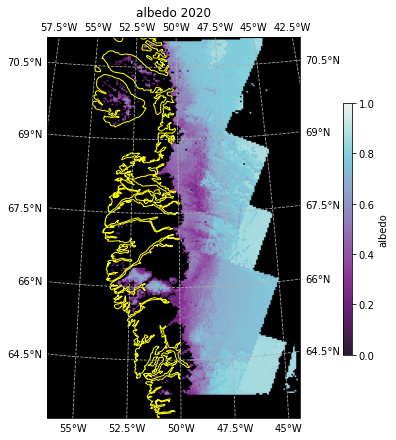

In [ ]:
region = [xMin, yMin, xMax, yMax]

crsextent = [xMin+1, xMax, yMin-0.5, yMax]
fig = plt.figure(figsize=(6, 7))

ax = cartoee.get_map(albedoImage, region=region, vis_params=visParams, 
                     proj=ccrs.NearsidePerspective(
                         central_latitude=np.mean([yMin, yMax]),
                         central_longitude=np.mean([xMin, xMax]),
                         satellite_height=600000
)) # min_latitude=yMin.getInfo(), max_latitude=yMax.getInfo()

# add coastline
ax.set_extent(crsextent)
ax.coastlines(color="yellow")
cb = cartoee.add_colorbar(ax, vis_params=visParams, loc='right', label="albedo")
# fig.tight_layout();
ax.gridlines(draw_labels=True, linestyle='--')
ax.patch.set_facecolor('black') # ax.background_patch.set_facecolor('black')
# ax.set(title=titlestr)
# fig.savefig('darkzoneMax/' + titlestr + '.png', dpi=300, bbox_inches="tight")

In [4]:
df = pd.read_excel("darkzone.xlsx")
df['time']= df['time'].astype(str)

[Text(0.5, 0, ''), Text(0, 0.5, 'max dark zone area (km$^2$)')]

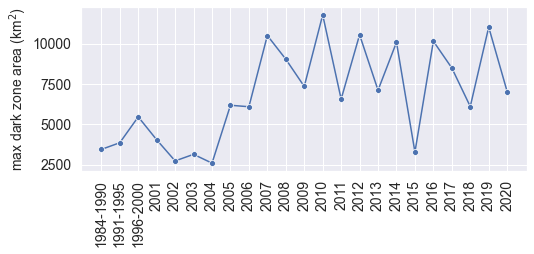

In [7]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.set_theme(style="darkgrid")
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 20
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
plt.rcParams["font.family"] = "Arial"
sns.lineplot(data=df, x='time', y='km2', marker="o")
ax.tick_params(axis='x', rotation=90)
ax.set(xlabel="", ylabel="max dark zone area (km$^2$)")
# fig.savefig("print/albedoAnomalyPoi.pdf", dpi=300, bbox_inches="tight")

## dark zone occurrence

In [14]:
# create filter for image collection
colFilter = ee.Filter.And(
    ee.Filter.geometry(aoi), # filterbounds not available on python api https://github.com/google/earthengine-api/issues/83
    ee.Filter.date(date_start, date_end),
    # ee.Filter.calendarRange(7, 8, 'month'),
    ee.Filter.dayOfYear(196, 227) # Jul 15 - Aug 15
)

s2colFilter =  ee.Filter.And(
    ee.Filter.geometry(aoi), # filterbounds not available on python api https://github.com/google/earthengine-api/issues/83
    ee.Filter.date(date_start, date_end),
    # ee.Filter.calendarRange(7, 8, 'month'),
    ee.Filter.dayOfYear(196, 227),
    ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50)
)

oliCol = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
            .filter(colFilter) \
            .map(prepOli) \
            .select(['viznirAlbedo']) # .select(['totalAlbedo']) or  .select(['viznirAlbedo'])
etmCol = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
            .filter(colFilter) \
            .map(prepEtm) \
            .select(['viznirAlbedo']) # .select(['totalAlbedo']) or  .select(['viznirAlbedo'])
tmCol = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
            .filter(colFilter) \
            .map(prepEtm) \
            .select(['viznirAlbedo']) # .select(['totalAlbedo']) or  .select(['viznirAlbedo'])
tm4Col = ee.ImageCollection('LANDSAT/LT04/C02/T1_L2') \
            .filter(colFilter) \
            .map(prepEtm) \
            .select(['viznirAlbedo']) # .select(['totalAlbedo']) or  .select(['viznirAlbedo'])
s2Col = ee.ImageCollection('COPERNICUS/S2_SR') \
            .filter(s2colFilter) \
            .map(prepS2) \
            .select(['viznirAlbedo']) # .select(['totalAlbedo']) or  .select(['viznirAlbedo'])
landsatCol = oliCol.merge(etmCol).merge(tmCol).merge(tm4Col)
multiSat = landsatCol.merge(s2Col).map(imRangeFilter).sort('system:time_start', True)


In [15]:
date_init = ee.Date.fromYMD(1984, 1, 1)
# Difference between start and finish
diff = date_end.difference(date_init, 'year')

# Make a list of all dates
timestep = 1; 

range = ee.List.sequence(0, diff.subtract(1), timestep).map(lambda year: date_init.advance(year, 'year'))

# Funtion for iteraton over the range of dates
def getMonthly(date, newlist):
  # Cast
    date = ee.Date(date)
    newlist = ee.List(newlist)

    # Filter collection between date and the next day
    filtered = multiSat.filterDate(date, date.advance(timestep,'year'))
    #   nimproperty = filtered.get()
    # Make the mosaic
    image = ee.Image(
        filtered.mean().copyProperties(filtered.first())) \
        .set('system:time_start', filtered.first().get('system:time_start'))

    # Add the mosaic to a list only if the collection has images
    return ee.List(ee.Algorithms.If(filtered.size(), newlist.add(image), newlist))

annualAlbedo = ee.ImageCollection(ee.List(range.iterate(getMonthly, ee.List([]))))




In [16]:
nonNullNum = annualAlbedo.reduce(
    ee.Reducer.count()
)

def getOccurence(image):
    mask = image.lt(0.45).rename('darkzone')
    return image.addBands(mask)

darkzoneOccurrence = annualAlbedo.map(getOccurence).sum().divide(nonNullNum).updateMask(greenlandmask)

In [17]:
# Export the image to an Earth Engine asset.
task = ee.batch.Export.image.toAsset(**{
  'image': darkzoneOccurrence,
  'description': 'darkzoneOccurrence19842020p45',
  'assetId': 'projects/ee-deeppurple/assets/darkzone/darkzoneOccurrence8420p45',
  'scale': 30,
  'region': aoi,
  'maxPixels':1e13
})
task.start()

# while task.active():
#   print('Polling for task (id: {}).'.format(task.id))
#   time.sleep(5)